
<img src="img/logo.gif" align="center" width="240" />


## Problem Statement

A bank wants to have a model that helps to predict whether a client will subscribe for a term deposit or not, based on the relevant data available with the bank. 

As a data scientist, we are required to construct a classification model based on the available data and evaluate its efficacy. 

The general activities to perform KDD include
1. Preparing the dataset for analysis
2. Investigating the relationships in the data set with visualization
3. Creating a model
4. Evaluating the performance of the classification model.

### KDD Process on Bank Data:

The KDD process is described in detail with the following activities,
1. <a href="#LoadDataset">Loading of dataset</a>
2. <a href="#EDA">Perform Eploratory Data Analysis(EDA)</a>
3. <a href="#DataPreprocessing">Data pre-processing</a>
4. <a href="#SplitTrain">Spliting training and testing data</a>
5. <a href="#TrainModel">Train and Build the model</a>
6. <a href="#TestModel">Test the model(Predicting with test data)</a>
7. <a href="#EvalModel">Evaluate the model performance</a>
8. <a href="#Optimization">Optimization and improvements of model efficiency</a>



## 0. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")

# Matplotlib library
import matplotlib.pyplot as plt
%matplotlib inline

# Importing sklearn libraries for preprocessing, train test splitting, 
# model building, evaluation and optimization purpose
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

#Random forest tree
from sklearn.ensemble import RandomForestClassifier

from pprint import pprint

import seaborn as sns
#import missingno as msno

from matplotlib import rcParams

# rcParams['figure.figsize'] = 10,6

<a name="LoadDataset"></a>

## 1. Loading of Dataset

The data will be loaded from the given dataset file. Here, the data is given in the form of MS Excel. We need to load the data into a Dataframe to process further. 
<a name="loading_data" />

In [2]:
# Bank dataset from spreadsheet file
bank_data = pd.read_excel('data/Bank Data for case study assignment.xlsx', sheet_name='Data', header=0)

The default attributes have space and `?` in the name. We need to remove the special characters to make the attributes name as consistent.

In [3]:
# Rename the columns
bank_data.rename(columns={'age':'Age', 'job': 'Job', 'marital status': 'Marital status','education':'Education','credit default?': 'Credit default', 'housing loan?': 'Housing loan', 'y': 'Term deposit'}, inplace=True)

# Breif look on the data
bank_data.head()

,Age,Job,Marital status,Education,Credit default,Housing loan,Personal loan,Term deposit
0,30,unemployed,married,primary,no,no,no,no
1,33,services,married,secondary,no,yes,yes,no
2,35,management,single,tertiary,no,yes,no,no
3,30,management,married,tertiary,no,yes,yes,no
4,59,blue-collar,married,secondary,no,yes,no,no


<a name="EDA"></a>

## 2. Exploratory Data Analysis(EDA)

Exploratory Data Analysis(EDA) will help us to understand the data more on performing the KDD process further. The data will be explored statistically to see the quality and nature of the data.


In [4]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             1021 non-null   int64 
 1   Job             1019 non-null   object
 2   Marital status  1020 non-null   object
 3   Education       1020 non-null   object
 4   Credit default  1020 non-null   object
 5   Housing loan    1019 non-null   object
 6   Personal loan   1019 non-null   object
 7   Term deposit    1021 non-null   object
dtypes: int64(1), object(7)
memory usage: 63.9+ KB


Except the atribute `Age`, all other attributes are categorical attributes

In [5]:
bank_columns = bank_data.columns
bank_columns

Index(['Age', 'Job', 'Marital status', 'Education', 'Credit default',
       'Housing loan', 'Personal loan', 'Term deposit'],
      dtype='object')

### Statistical Summary

The dataset contains most of the attributes as a categorical data. The general statistical summary such as mean, median, std and five-point summary can not be applied to all. Only the Age attribute is a numeric field hence the statistical summary can be applied there. 

In [6]:
print(bank_data.describe())
print("=="*40)
print("Mode value of categorical attributes: ")
for col in bank_data.columns:
    print("\r {0} = {1}".format(col, bank_data[col].mode().values[0]))

               Age
count  1021.000000
mean     41.066601
std      10.400013
min      19.000000
25%      33.000000
50%      39.000000
75%      48.000000
max      84.000000
Mode value of categorical attributes: 
 Age = 32
 Job = blue-collar
 Marital status = married
 Education = secondary
 Credit default = no
 Housing loan = yes
 Personal loan = no
 Term deposit = no


### Missing values in the dataset

In [7]:
bank_data.isnull().sum()

Age               0
Job               2
Marital status    1
Education         1
Credit default    1
Housing loan      2
Personal loan     2
Term deposit      0
dtype: int64

The below heatmap shows the null values in the attribute. We can see the null values as thin line across the attributes.

In [8]:
#sns.heatmap(bank_data.isnull(), cmap='viridis', fmt='.2g')

In [9]:
#msno.bar(bank_data, figsize=(8,6), fontsize=14, color='darkgray' )

### Noisy Data

Noisy data are the ones do not give any meaning to the attribute. The noisy data create inconsistency in the data.

Let us iterate through the data to find the unique values that are encompassed by the attribute. We can identify the inconsistant data that are present in the columns.

In [10]:
# Iterate through the columns and 
# pass the column name in the bank dataframe
for col in bank_data.columns:
    print("Unique values of {0}:\t=>{1}".format(col, pd.unique(bank_data[col])))

Unique values of Age:	=>[30 33 35 59 36 39 41 43 20 31 40 56 37 25 38 42 44 26 55 67 53 68 32 49
 78 23 52 34 61 45 48 57 54 63 51 29 50 27 60 28 21 58 22 46 24 77 75 47
 70 65 64 62 66 19 71 69 84]
Unique values of Job:	=>['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired' nan
 'unknown']
Unique values of Marital status:	=>['married' 'single' 'divorced' nan]
Unique values of Education:	=>['primary' 'secondary' 'tertiary' 'unknown' nan]
Unique values of Credit default:	=>['no' 'yes' nan]
Unique values of Housing loan:	=>['no' 'yes' nan 'xxxyy']
Unique values of Personal loan:	=>['no' 'yes' nan]
Unique values of Term deposit:	=>['no' 'yes']


In [11]:
education_count = bank_data['Education'].value_counts()
job_count = bank_data['Job'].value_counts()
house_loan_count = bank_data['Housing loan'].value_counts()
Marital_status_count = bank_data['Marital status'].value_counts()

print("Education Attribute :\n{0} ".format(education_count))
print("--"*50)
print("Job Attribute :\n{0} ".format(job_count))
print("--"*50)
print("House Loan Attribute :\n{0} ".format(house_loan_count))

Education Attribute :
secondary    524
tertiary     303
primary      151
unknown       42
Name: Education, dtype: int64 
----------------------------------------------------------------------------------------------------
Job Attribute :
blue-collar      217
management       212
technician       178
admin.           107
services          93
self-employed     52
retired           46
entrepreneur      32
unemployed        29
student           23
housemaid         20
unknown           10
Name: Job, dtype: int64 
----------------------------------------------------------------------------------------------------
House Loan Attribute :
yes      583
no       435
xxxyy      1
Name: Housing loan, dtype: int64 


### Plotting the data value distribution

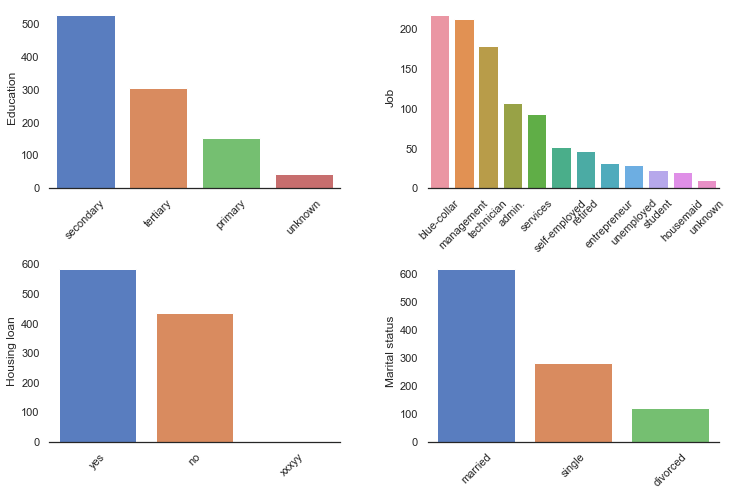

In [12]:
sns.set(style='white', palette='muted', color_codes=True)

fig, axes = plt.subplots(2, 2, figsize=(12,8), sharex=False)
sns.despine(left=True)

# Education count
sns.barplot(education_count.index, education_count, ax=axes[0,0])
# axes[0,0].set_xticks(Rotation=60)
sns.barplot(job_count.index, job_count, ax=axes[0,1])

sns.barplot(house_loan_count.index, house_loan_count, ax=axes[1,0])

sns.barplot(Marital_status_count.index, Marital_status_count, ax=axes[1,1])
plt.setp(plt.gcf().get_axes(), xlabel='');
fig.subplots_adjust(wspace=0.3, hspace=0.4)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
plt.show()

**Target Attribute**
The target attribute `y` or Term Deposit is a categorical attribute. The count distribution count can be views as below,

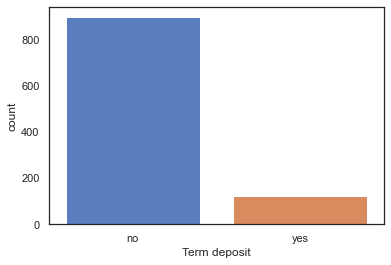

In [13]:
sns.countplot(x='Term deposit', data=bank_data, palette="muted")

<a name="DataPreprocessing"></a>

## 3. Data Pre-processing

The quality of the data that was explored during the EDA step will get corrected in data pre-processing stage. Generally the data pre-processing gets started with the filling the missing values and followed by removing noisy data, integrating various data element sources, data transformation and data reduction. 

### Reducing the noisy data

The inconsistent noisy data will get replaced by the NaN value so that it will get imputed with actual values. 

In [14]:
# Replacing the unknown and xxxyy value to nan
for col in bank_data.columns:
    bank_data[col].replace('unknown', np.nan, inplace=True)
    bank_data[col].replace('xxxyy', np.nan, inplace=True)
    
education_count = bank_data['Education'].value_counts()
job_count = bank_data['Job'].value_counts()
house_loan_count = bank_data['Housing loan'].value_counts()

print("Job attribute :\n{0}".format(job_count))
print("--"*40)
print("Education attribute :\n{0}".format(education_count))
print("--"*40)
print("House loan attribute :\n{0}".format(house_loan_count))


Job attribute :
blue-collar      217
management       212
technician       178
admin.           107
services          93
self-employed     52
retired           46
entrepreneur      32
unemployed        29
student           23
housemaid         20
Name: Job, dtype: int64
--------------------------------------------------------------------------------
Education attribute :
secondary    524
tertiary     303
primary      151
Name: Education, dtype: int64
--------------------------------------------------------------------------------
House loan attribute :
yes    583
no     435
Name: Housing loan, dtype: int64


### Mode values

Mode denotes the most-frequently occuring value in an attribute. The following information provides the mode values of Job, Education and Houseloan attributes

In [15]:
for col in bank_data.columns:
    print("Mode of {0} is {1}".format(col, bank_data[col].mode()))

Mode of Age is 0    32
dtype: int64
Mode of Job is 0    blue-collar
dtype: object
Mode of Marital status is 0    married
dtype: object
Mode of Education is 0    secondary
dtype: object
Mode of Credit default is 0    no
dtype: object
Mode of Housing loan is 0    yes
dtype: object
Mode of Personal loan is 0    no
dtype: object
Mode of Term deposit is 0    no
dtype: object


### Imputing the missing values

Imputing the missing values is a critical step in statistical analysis where the missing values will get replaced either by a mean, median or mode value.

In [16]:
# Missing columns list has a column names that have empty cell
missing_cols = [col for col in bank_data if bank_data[col].isnull().any()]
# Simple imputer object with replacement strategy as most frequent data
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

cleaned_data = pd.DataFrame(imputer.fit_transform(bank_data), columns=bank_data.columns)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             1021 non-null   object
 1   Job             1021 non-null   object
 2   Marital status  1021 non-null   object
 3   Education       1021 non-null   object
 4   Credit default  1021 non-null   object
 5   Housing loan    1021 non-null   object
 6   Personal loan   1021 non-null   object
 7   Term deposit    1021 non-null   object
dtypes: object(8)
memory usage: 63.9+ KB


### Data Transformation

The categorical data needs to be transformed to suitable numerical data to fit into a ML algorithm. One of the approach in transforming the categorical data into a number is Indexing. The indexing technique implies that every category will have mapped unique numerical value so that it can be refered back at any point of time.   

In [17]:
# LabelEncoder object initilization
lbl_encoder = LabelEncoder()

# Taking all non-numeric columns
non_num_cols = [col for col in bank_data.columns if bank_data[col].dtypes != np.int64]

# Iterate through the non-numeric columns
for col in non_num_cols:
   cleaned_data[col] = lbl_encoder.fit_transform(cleaned_data[col]) # Fit and Transform the categorical data
# Sample of transformed data
cleaned_data.head(10)

,Age,Job,Marital status,Education,Credit default,Housing loan,Personal loan,Term deposit
0,30,10,1,0,0,0,0,0
1,33,7,1,1,0,1,1,0
2,35,4,2,2,0,1,0,0
3,30,4,1,2,0,1,1,0
4,59,1,1,1,0,1,0,0
5,35,4,2,2,0,0,0,0
6,36,6,1,2,0,1,0,0
7,39,9,1,1,0,1,0,0
8,41,2,1,2,0,1,0,0
9,43,7,1,0,0,1,1,0


### Relationship between the attributes

The relationship between the attributes will help us in understanding more on the dataset. The relationship can be identified by using correlation coefficient analysis. If the data fields are categorical the chi-square method will be used to see the relationship. 

In [18]:
cleaned_data.Age = cleaned_data.Age.astype(np.int32)

cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021 entries, 0 to 1020
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             1021 non-null   int32
 1   Job             1021 non-null   int32
 2   Marital status  1021 non-null   int32
 3   Education       1021 non-null   int32
 4   Credit default  1021 non-null   int32
 5   Housing loan    1021 non-null   int32
 6   Personal loan   1021 non-null   int32
 7   Term deposit    1021 non-null   int32
dtypes: int32(8)
memory usage: 32.0 KB


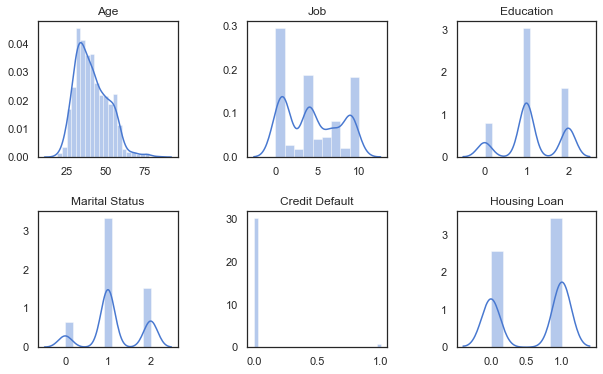

In [19]:
fig, axes = plt.subplots(2,3,figsize=(10,6), sharex=False)

sns.distplot(cleaned_data['Age'], ax=axes[0][0])
axes[0][0].set_title('Age')
sns.distplot(cleaned_data['Job'], ax=axes[0][1])
axes[0][1].set_title('Job')
sns.distplot(cleaned_data['Education'], ax=axes[0][2])
axes[0][2].set_title('Education')
sns.distplot(cleaned_data['Marital status'], ax=axes[1][0])
axes[1][0].set_title('Marital Status')
sns.distplot(cleaned_data['Credit default'], ax=axes[1][1])
axes[1][1].set_title('Credit Default')
sns.distplot(cleaned_data['Housing loan'], ax=axes[1][2])
axes[1][2].set_title('Housing Loan')
plt.setp(plt.gcf().get_axes(), xlabel='');
fig.subplots_adjust(wspace=0.5, hspace=0.4)
plt.show()

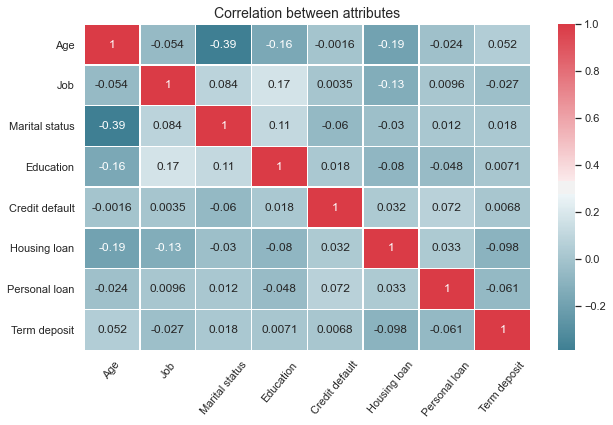

In [20]:
cm = np.corrcoef(cleaned_data.values.T)
cols = bank_columns
plt.figure(figsize=(10,6))

#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cm, linewidth = 0.5, cmap=colormap, annot=True, xticklabels=cols, yticklabels=cols)
plt.title("Correlation between attributes", fontsize=14)
plt.xticks(rotation=50)
plt.show()

<a name="SplitTrain"></a>

## 4. Preparing train and test data

The dataset needs to be splited to prepare training set and test set. Usually the testset split size is `0.20% to 0.33%` of the dataset. This will ensure that the model is not overfitted with too many similar instances. 

In [21]:
y = cleaned_data['Term deposit']
X = cleaned_data.drop('Term deposit', axis=1)

print("Predictors: {0}".format(X.columns.values))

Predictors: ['Age' 'Job' 'Marital status' 'Education' 'Credit default' 'Housing loan'
 'Personal loan']


In [22]:
# Parameters
test_split = 0.30
random_number = 101

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=random_number)

print("Shape of Trainingset {0}".format(X_train.shape))
print("Shape of Testset {0}".format(X_test.shape))

Shape of Trainingset (714, 7)
Shape of Testset (307, 7)


<a name="TrainModel"></a>

## 5. Build Model

The model building step consists of choosing a right algorithm to fit the training data and use the model for evaluating its efficiency in predicting the data. The selection of algorithm is based on the values of target variable.

If the target variable contains 2 class data then it is a **`Binary classification`**, whereas the same contains more than 2 class data then its a **`Multiclass classification`**.

In our problem, the dataset target variable **`Term Deposit`** contains 2 class as `Yes` and `No`. Hence, its a binary classification. 
For binary classification and most of the attributes have categorical data, we will try with the following 2 tree based  algorithm,
1. Decision Tree
2. Random Forest

In [23]:
# Decision Tree model
dtree_classifier = DecisionTreeClassifier()

# Fitting the model with trainset data
dtree_classifier.fit(X_train, y_train)

print("Decision Tree model default parameters:\n")
pprint(dtree_classifier.get_params())

Decision Tree model default parameters:

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}


In [24]:
# Random Forest classifier model
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

print("Random Forest classifier model default parameters:\n")
pprint(rf_classifier.get_params())

Random Forest classifier model default parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


<a name="TestModel"></a>

## 6. Test the model(Predicting data)

In [25]:
dt_pred = dtree_classifier.predict(X_test)
rf_pred = rf_classifier.predict(X_test)

print("Accuracy of Decision Tree Classifier : {0}".format(accuracy_score(y_test, dt_pred)))
print("Accuracy of Random Forest Classifier : {0}".format(accuracy_score(y_test, rf_pred)))

Accuracy of Decision Tree Classifier : 0.8110749185667753
Accuracy of Random Forest Classifier : 0.8566775244299675


<a name="EvalModel"></a>

## 7. Evaluation Model

Classification report for the algorithm `DecisionTreeClassifier`.

In [26]:
print("Confusion Matrix of Decision Tree: \n{0}".format(confusion_matrix(dt_pred,y_test)))
print("--"*20)
print("Confusion Matrix of Random Forest: \n{0}".format(confusion_matrix(rf_pred,y_test)))


Confusion Matrix of Decision Tree: 
[[244  27]
 [ 31   5]]
----------------------------------------
Confusion Matrix of Random Forest: 
[[261  30]
 [ 14   2]]


In [27]:
print("Classification report of Decision Tree: \n{0}".format(classification_report(dt_pred,y_test)))
print("--"*50)
print("Classification report of Random Forest: \n{0}".format(classification_report(rf_pred,y_test)))


Classification report of Decision Tree: 
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       271
           1       0.16      0.14      0.15        36

    accuracy                           0.81       307
   macro avg       0.52      0.52      0.52       307
weighted avg       0.80      0.81      0.81       307

----------------------------------------------------------------------------------------------------
Classification report of Random Forest: 
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       291
           1       0.06      0.12      0.08        16

    accuracy                           0.86       307
   macro avg       0.51      0.51      0.50       307
weighted avg       0.90      0.86      0.88       307



<a name="Optimization"></a>

## 8. Optimization to improve the model efficiency

Optimization of machine learning deals with,
* how to deal with data more effectively
* how to estimate the computational load for processing a large data set
* how to avoid local minima and search a good solution from a complex multi-dimensional space.

**Hyperparameters**

Machine learning models are parameterized so that their behavior can be tuned for a given problem. These models can have many parameters and finding the best combination of parameters can be treated as a search problem.


**Decision Tree Parameters**
1. Criterion(default='gini'): the parameter allows to use the different attributes selection measures. 
2. Splitter(default='best'): Split strategy are 'best' and 'random' to choose random split.
3. max_depth(default='None'): Maximum depth of the tree, 


**Random Forest Parameters**

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [28]:
# Grid search for different model
def get_best_params(model, parameters, X, y):
    n_jobs = 3 # No. of jobs to be run
    k_folds = 3 # K-Folds to be specified as a parameters
    
    if model == 'DT':
        estimator = DecisionTreeClassifier()
    else:
        estimator = RandomForestClassifier()
    # Initialize grid search
    grid_search = GridSearchCV(estimator, param_grid=parameters, n_jobs=n_jobs, cv=k_folds)
    
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_

# Creating parameters for each classifier


### Creating parameters value set 

We need to create parameters set for each classifier to see the best parameters that gives a better accuracy. 


In [29]:
# Decision Tree parameters set
dt_grid = {'max_depth':range(3,30), 'min_samples_leaf': np.arange(1,6), 'min_samples_split': np.arange(2,6)}

# RandomForest - Random parameter grid
# Number of trees in the forest
n_estimators = [int(n) for n in np.linspace(start=200, stop=2000, num=10)]
# Maximum features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in the tree
max_depth = [int(d) for d in np.linspace(start=10, stop=110, num=11)]
# Maximum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at the each leaf node
min_sample_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Grid for RandomForest classifier
rf_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth, 
                'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_sample_leaf, 
              'bootstrap': bootstrap}


### Applying parameters in GridSearchCV

In [30]:
# Gridsearch for decision tree classifier
dt_best_params = get_best_params('DT', dt_grid, X_train, y_train)
pprint(dt_best_params)

DecisionTreeClassifier(max_depth=3)


**Optimized Parameters for Decision Tree Classifier**

* max_depth=3
* min_samples_leaf = 1
* min_samples_split =2

In [31]:
from sklearn.model_selection import RandomizedSearchCV

rfc = RandomForestClassifier() # Estimator object

# Random forest search cross-validation
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=rf_grid, n_iter=100, cv=3, random_state=42, n_jobs=-1)

# Fitting the data in the search cross validation
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [32]:
print("Optimized parameters for RandomForestClassifier")
random_search.best_params_

Optimized parameters for RandomForestClassifier


{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

### Refitting the model with best/optimized parameters

The best parameters of each classifier will be used to build the model and predict the data to check whether the prediction efficiency has been improved or not.


### Decision Tree Classifier

In [33]:
dtree_model = DecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1, splitter='best')

dtree_model.fit(X_train, y_train)

# Predicting the test data
dt_preds = dtree_model.predict(X_test)
print("Decision Tree accuracy score: {0}".format(accuracy_score(y_test, dt_preds)))

Decision Tree accuracy score: 0.8957654723127035


### Random Forest Classifier

In [34]:
rfc = RandomForestClassifier(n_estimators=1000, min_samples_leaf=4, min_samples_split=10, max_depth=20, max_features='sqrt', bootstrap=True)
rfc.fit(X_train, y_train)
rnf_preds = rfc.predict(X_test)
print("RandomForestClassifier accuracy score: {0}".format(accuracy_score(y_test, rnf_preds)))

RandomForestClassifier accuracy score: 0.8957654723127035


### Metrics of optimized model

The metrics of optimized model should be calculated to check the efficiency improvement.

**Confusion Matrix**

In [35]:
print("Confusion Matrix of Decision Tree: \n{0}".format(confusion_matrix(dt_pred,y_test)))
print("--"*20)
print("Confusion Matrix of Random Forest: \n{0}".format(confusion_matrix(rnf_preds,y_test)))


Confusion Matrix of Decision Tree: 
[[244  27]
 [ 31   5]]
----------------------------------------
Confusion Matrix of Random Forest: 
[[275  32]
 [  0   0]]


**Classification Report**

In [36]:
print("Classification report of Decision Tree: \n{0}".format(classification_report(dt_preds,y_test)))
print("--"*50)
print("Classification report of Random Forest: \n{0}".format(classification_report(rnf_preds,y_test)))

Classification report of Decision Tree: 
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       303
           1       0.06      0.50      0.11         4

    accuracy                           0.90       307
   macro avg       0.53      0.70      0.53       307
weighted avg       0.98      0.90      0.93       307

----------------------------------------------------------------------------------------------------
Classification report of Random Forest: 
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       307
           1       0.00      0.00      0.00         0

    accuracy                           0.90       307
   macro avg       0.50      0.45      0.47       307
weighted avg       1.00      0.90      0.95       307



## Conclusion

The bank term deposit data has been analysed, cleaned and prepared trainset and test for building a classification model. There are three different classifier algorithms used to build the model to see the efficiency in predicting the data. 

| Classifier | Accuracy score with default Parameter  | Accuracy score after Optimization  | 
|------------|----------------------------------|---------------------|
|  Decision Tree Classifier |  0.827 => **83%** |  0.8957 * 100 = **89.5%** |  
| Random Forest Classifier  |  0.856 => **86%** |  0.8957 * 100 = **89.5%** | 



After optimization activity the best parameters are used to build a model. Both `decision tree` and `random forest classifier` showed a significant improvements. 

Both the tree based classifier algorithms have performed similarly with **89.5%** of accuracy score. 

## Thank You. 
